# PPO to Play `CartPole-v1` in Tensorflow 2.0

As usual, our easiest way to test if we have implemented an agent correctly is to test it on a simple environment such as `CartPole-v1` or `MountainCar-v0`. Here we used the [PPO-clip](https://spinningup.openai.com/en/latest/algorithms/ppo.html#pseudocode) implementation in Pytorch from [eungeunrho/minimalRL](https://github.com/seungeunrho/minimalRL) as base to create our TF2 agent. This implementation is especially interesting in that it is written in a way that the agent itself is treated as a differentiable model and we can optimize the actor and critic simultaneously by apply gradients to the entire agent.

## Imports

In [6]:
# #uncomment if you are running from colab
# # %tensorflow_version 2.x
# !pip install tensorflow-probability==0.8
# import tensorflow_probability as tfp
# !git clone https://github.com/cstorm125/lepetite.git
# !mv lepetite lepetite_folder
# !mv lepetite_folder/lepetite .
# !ls

In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_probability as tfp

import gym
from collections import deque
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt

from lepetite import agents 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## PPO-Clip Agent

Proximal policy optimization (PPO) is a policy gradient algorithm that sorts to find the largest improvement step that does not destabilize the training. Instead of finding trust regions like TRPO, PPO instead resort to using either constant bounds (PPO-Clip) or KL divergence term penalty (PPO-Penalty). Here we will implement PPO-Clip as a `Model` in Tensorflow 2.

## Networks

Like all policy gradient agents that use advantage as a baseline, PPO requires 

1. **Actor network** to take input of state and output action probabilities
2. **Critic network** to take input of state and output state values

**Coding Assignment** Implement an actor and a critic for our PPO agent. The actor and critic can share a feature extraction layer.

In [ ]:
class PPOCategorical(Model):
    def __init__(self, input_dim = 4, hidden_dims = [64], output_dim = 2, lr = 5e-4,
                gamma=1, lamb=0.95, eps_clip=0.1):
        super(PPOCategorical, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.lr = lr
        self.gamma = gamma
        self.lamb = lamb
        self.eps_clip = eps_clip
        
        self.loss_lst = []
        self.trajectories = []
        
        '''
        Fill in the codes
        '''
#         self.features  = tf.keras.Sequential()
#         self.actor = tf.keras.Sequential()
#         self.critic  = tf.keras.Sequential()
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        
    def act(self, x):
        '''
        Fill in the codes
        '''
        pass
    
    def critique(self, x):
        '''
        Fill in the codes
        '''
        pass

In [ ]:
env = gym.make('CartPole-v1')
state = env.reset()
state = tf.convert_to_tensor(state,dtype=tf.float32)[None,:]
state

## Trajectories

Unlike value-based strategies like DQN, PPO is an on-policy algorithm and only uses the **trajectories** that result from the current interactions with the environment. It does not save those trajectories `(states,actions,rewards,next_states,probs,dones)` to replay memory to be used later like DQN.

In [ ]:
def add(self, *args):
    t = {'state':args[0],'action':args[1],'reward':args[2],
         'next_state':args[3],'prob':args[4],'done':args[5]}
    self.trajectories.append(t)

def make_batch(self):
    states = tf.convert_to_tensor([t['state'] for t in self.trajectories],dtype=tf.float32)
    actions = tf.convert_to_tensor([[t['action']] for t in self.trajectories],dtype=tf.int32)
    rewards = tf.convert_to_tensor([[t['reward']] for t in self.trajectories],dtype=tf.float32)
    next_states = tf.convert_to_tensor([t['next_state'] for t in self.trajectories],dtype=tf.float32)
    probs = tf.convert_to_tensor([[t['prob']] for t in self.trajectories],dtype=tf.float32)
    dones = tf.convert_to_tensor([[float(t['done'])] for t in self.trajectories],dtype=tf.float32)
    self.trajectories = []
    return states,actions,rewards,next_states,probs,dones

## [Generalized Advantage Estimation (GAE)](https://arxiv.org/abs/1506.02438)

Recall [N-step bootstrapping](http://incompleteideas.net/book/bookdraft2017nov5.pdf) from [Rainbow](https://github.com/ekapolc/RL_course_2019/blob/master/slides/L07%20-%20practical%20rl%20and%20rainbow.ipynb):

* Monte Carlo
$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^T-t-1 R_{terminal}$$
* TD (1-step bootstrapping)
$$G_t = R_{t+1} + \gamma V_t(S_{t+1})$$
* 2-step bootstrapping
$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 V_t(S_{t+2})$$
* N-step bootstrapping
$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{n-1}R_{t+n} + \gamma^n V_{t+n-1}(S_{t+n})$$


![nstep.png](https://i.postimg.cc/JzsjZKZW/nstep.png)

This is done in order to balance the bias (low in Monte Carlo) versus variance (low in TD) tradeoff. GAE is simply taking this concept further by exponentially weighting each n-step return $G^{n}_t$ by $\lambda$. Here you can substitute discounted rewards with advantage $A^{n}_t$ also.

\begin{align}
\hat{A}_t^{GAE(\gamma,\lambda)} &= (1-\lambda)\Big(\hat{A}_{t}^{(1)} + \lambda \hat{A}_{t}^{(2)} + \lambda^2 \hat{A}_{t}^{(3)} + \cdots \Big) \\
&= (1-\lambda)\Big(\delta_t^V + \lambda(\delta_t^V + \gamma \delta_{t+1}^V) + \lambda^2(\delta_t^V + \gamma \delta_{t+1}^V + \gamma^2 \delta_{t+2}^V)+ \cdots \Big)  \\
&= (1-\lambda)\Big( \delta_t^V(1+\lambda+\lambda^2+\cdots) + \gamma\delta_{t+1}^V(\lambda+\lambda^2+\cdots) + \cdots \Big) \\
&= (1-\lambda)\left(\delta_t^V \frac{1}{1-\lambda} + \gamma \delta_{t+1}^V\frac{\lambda}{1-\lambda} + \cdots\right) \\
&= \sum_{l=0}^\infty (\gamma \lambda)^l \delta_{t+l}^{V}
\end{align}

In [ ]:
g = [1,2,4,8,16]
gamma = 0.9
lamb = 0.5
adv = 0
adv_list = []
for g_t in g[::-1]:
    adv = (gamma*lamb*adv) + g_t
    print(f'g_t is {g_t} and adv is {adv}')
    adv_list.append(adv)
res_list.reverse()
print(res_list)

In [ ]:
def compute_gae(self, states, next_states, rewards, dones):
    q_targets = rewards + self.gamma * self.critique(next_states) * (1-dones)
    deltas = q_targets - self.critique(states)
    deltas = deltas.numpy()
    advantage_lst = []
    advantage = 0.0
    for delta_t in deltas[::-1]:
        advantage = (self.gamma * self.lamb * advantage) + delta_t[0]
        advantage_lst.append([advantage])
    advantage_lst.reverse()
    advantages = tf.convert_to_tensor(advantage_lst, dtype=tf.float32)
    return advantages

## Clipped Surrogate Function and Critic Loss

For the actor network, PPO does gradient ascent for the following surrogate function: 

![surrogate PPO](https://spinningup.openai.com/en/latest/_images/math/99621d5bcaccd056d6ca3aeb48a27bf8cc0e640c.svg)

This is basically the same as a typical actor-critic surrogate function except for the clipping for log-probability ratio.

For the critic network, PPO performs gradient descent for the loss comparing state value with the TD target.

**Coding Assignment** Fill in the codes for actor loss.

In [ ]:
def train(self, update_times=3):
    states,actions,rewards,next_states,probs,dones  = self.make_batch()
    for i in range(update_times):
        #q targets to optimize critic
        q_targets = rewards + self.gamma * self.critique(next_states) * (1-dones)
        #advantages to optimize actor
        advantages = self.compute_gae(states,next_states,rewards,dones)

        #train
        with tf.GradientTape() as tape:
            
            #actor loss
            preds = self.act(states)
            action_idxs = tf.stack([tf.range(tf.shape(actions)[0]),actions[:,0]],axis=-1)
            preds_a = tf.gather_nd(preds,action_idxs)[:,None]
            
            '''
            Fill in the codes
            '''
#             ratio = 0
#             surr1 = 0
#             surr2 = 0
#             actor_loss = 0
            
            #critic loss
            critic_loss_fn = tf.keras.losses.MeanSquaredError()
            critic_loss = critic_loss_fn(q_targets, self.critique(states))
            
            #combined loss
            loss = -actor_loss + critic_loss
            loss = tf.reduce_mean(loss)
            gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients,self.trainable_weights))
        self.loss_lst.append(loss.numpy())

## Training Loop

**Coding Assignment** With the help of `tensorflow_probability` library, output probability for each action then sample from a categorical distribution (`distributions.Categorical`) based on that probability. Run the training loop to see if the agent is learning.

In [ ]:
scores_deque = deque(maxlen=100) 
scores_mean = []
scores = []
env = gym.make('CartPole-v1')
agent = agents.PPOCategorical()
trajectory_len = 20

for e in tqdm_notebook(range(500)):
    state = env.reset()
    done = False
    score = 0
    while not done:
        for t in range(trajectory_len):
            '''
            Fill in the codes
            '''
#             prob = 0
#             m = 0
#             action = 0
            
            next_state, reward, done, info = env.step(action)
            score+=reward
            agent.add(state, action, reward/100, next_state, prob[0,action].numpy(), done)
            state = next_state
            if done: break
        agent.train()
    scores.append(score)
    scores_deque.append(score)
    scores_mean.append(np.mean(scores_deque))

    if e%100==0:
        print(f'Episode {e}: 100-episode moving average at {scores_mean[-1]}')
    if scores_mean[-1] > 100: 
        print(f'Solved at {e} {scores_mean[-1]}')
        break

env.close()

## Solutions

In [4]:
scores_deque = deque(maxlen=100) 
scores_mean = []
scores = []
env = gym.make('CartPole-v1')
agent = agents.PPOCategorical()
trajectory_len = 20

for e in tqdm_notebook(range(500)):
    state = env.reset()
    done = False
    score = 0
    while not done:
        for t in range(trajectory_len):
            '''
            Fill in the codes
            '''
            prob = agent.act(tf.convert_to_tensor(state,dtype=tf.float32)[None,:])
            m = tfp.distributions.Categorical(probs=prob)
            action = m.sample().numpy()[0]
            
            next_state, reward, done, info = env.step(action)
            score+=reward
            agent.add(state, action, reward/100, next_state, prob[0,action].numpy(), done)
            state = next_state
            if done: break
        agent.train()
    scores.append(score)
    scores_deque.append(score)
    scores_mean.append(np.mean(scores_deque))

    if e%100==0:
        print(f'Episode {e}: 100-episode moving average at {scores_mean[-1]}')
    if scores_mean[-1] > 100: 
        print(f'Solved at {e} {scores_mean[-1]}')
        break

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Episode 0: 100-episode moving average at 29.0
Episode 100: 100-episode moving average at 28.93
Solved at 182 101.99


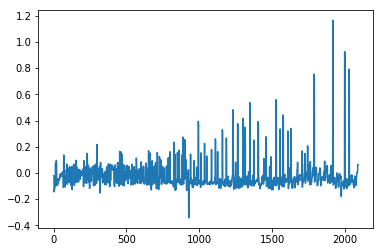

In [7]:
plt.plot(agent.loss_lst)

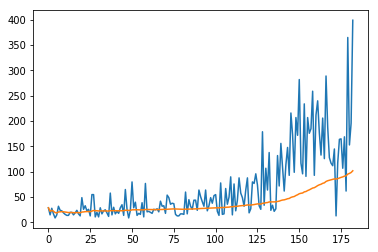

In [8]:
plt.plot(scores)
plt.plot(scores_mean)